## Loading the dataset

from https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?resource=download

In [12]:
import torch
import numpy as np
import pandas as pd
import glob ## to grap the files easily 
import matplotlib.pyplot  as plt


In [31]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
import cv2 ## help to read image 

###  Loading the images

### we need to adjust the dimensions, and also following the conventions (R,G B channels order)

In [4]:
tumor = []
path = "./brain_tumor_dataset/yes/*.jpg"
for image in glob.iglob(path):
    image = cv2.imread(image)
    image = cv2.resize(image, (128,128)) ## resize
    ## this is a convention
    b,g,r = cv2.split(image) ## return the channels blue green and red
    image = cv2.merge([r,g,b])
    tumor.append(image)

In [5]:
healthy = []
path = "./brain_tumor_dataset/no/*.jpg"
brain_tumor_dataset
for image in glob.iglob(path):
    image = cv2.imread(image)
    image = cv2.resize(image, (128,128)) ## resize
    ## this is a convention
    b,g,r = cv2.split(image) ## return the channels blue green and red
    image = cv2.merge([r,g,b])
    healthy.append(image)

In [6]:
healthy = np.array(healthy)
tumor= np.array(tumor)

In [7]:
tumor.shape

(86, 128, 128, 3)

In [8]:
healthy.shape

(85, 128, 128, 3)

In [21]:
merged = np.concatenate([healthy,tumor])
merged.shape

(171, 128, 128, 3)

## Let's visualiza an image

In [9]:
np.random.choice(10,5,replace=False) # sample 5 numbers, from 0 to 9   with no ripetition

array([9, 6, 7, 3, 8])

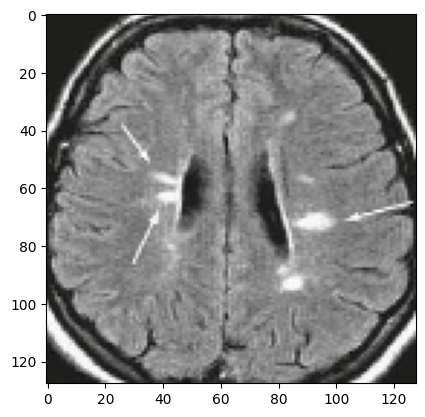

In [14]:
plt.imshow(healthy[0])

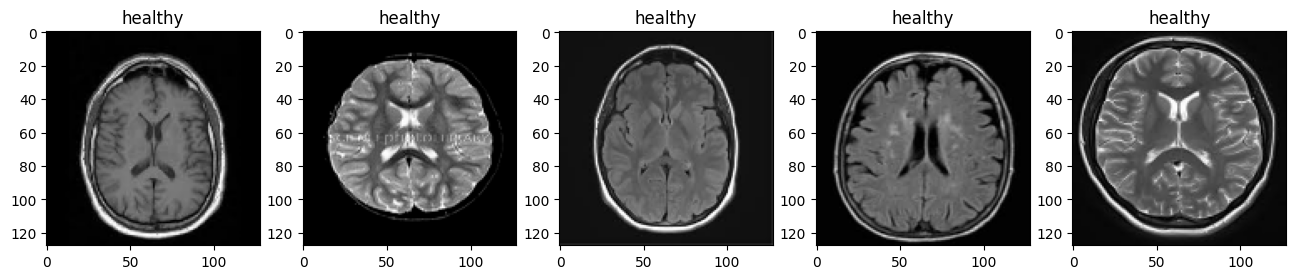

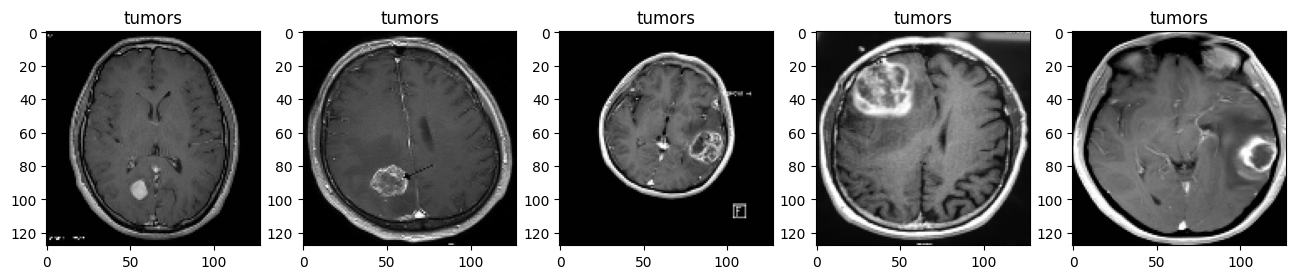

In [18]:
def  plot_random(healthy,tumor, num = 5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0],num,replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0],num,replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num): ## matplotlib starts from 1 differently from when using python
        plt.subplot(1,num, i+1) # 1 row with 5 columns, i want to allocate the neext image in the position i+1
        plt.title("healthy")
        plt.imshow(healthy_imgs[i])
    
    plt.figure(figsize=(16,9))
    for i in range(num): ## matplotlib starts from 1 differently from when using python
        plt.subplot(1,num, i+1) # 1 row with 5 columns, i want to allocate the neext image in the position i+1
        plt.title("tumors")
        plt.imshow(tumor_imgs[i])

plot_random(healthy,tumor, num = 5)

## Create Torch Dataset Class

### This is the abstract definition of pytorch

In [32]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

we need to implement getitem() and len()

In [33]:
class MRI(Dataset):
    def __init__(self,scores):
        self.x = scores
    def __getitem__(self, index):
        return self.x[index]
        

In [29]:
a = [12,3,7,7]
d = MRI(a)

In [30]:
d[2]

7

basically, the get_item method is the one invocked automatically when i use the []

and the same is done when using len(d) for the method __len__

actually the same is done when i use + 

## Let's create the custom dataset

## Here since i need to extract the features i use the previous code

In [43]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))



        
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    ## These are gray scale images so from 0 to 255
    ## Usually we normaliza either from -1 to 1 or from 0 to 1
    ## here i do the second option
    def normalize(self):
        self.images = self.images/255.0

In [47]:
mri = MRI()
mri.normalize()

In [48]:
len(mri)

171

## Let's print from the data loader using squeeze to remove one dimension ans reshape 

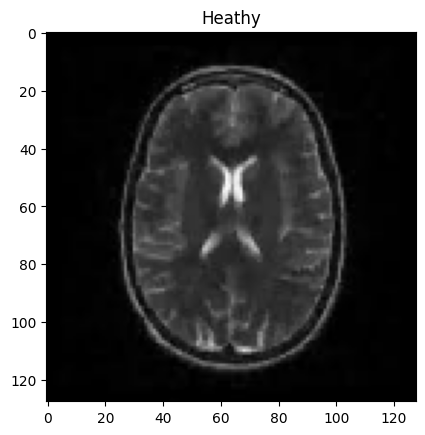

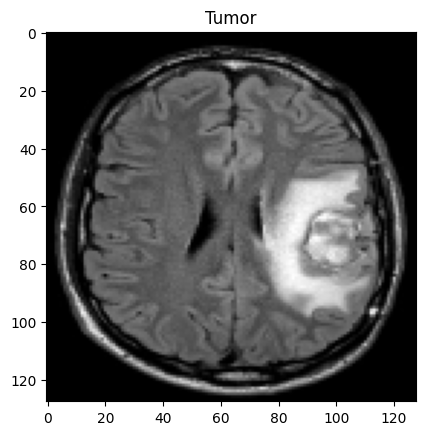

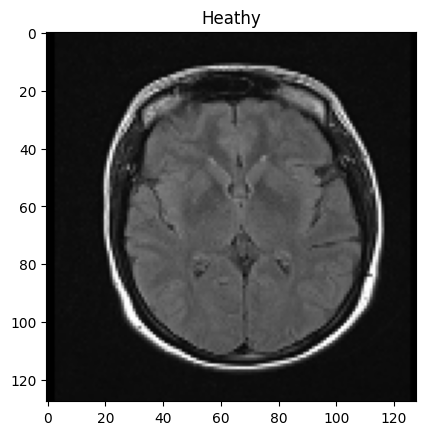

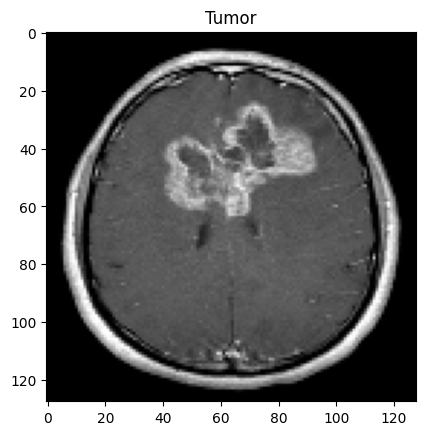

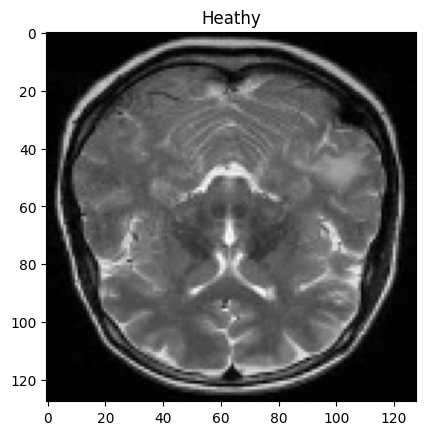

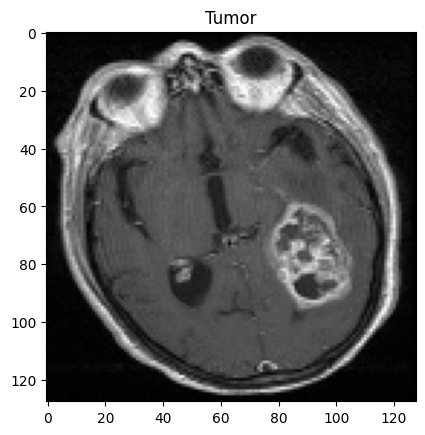

In [50]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

## understanding x.view(x.size(0), -1)

In [51]:
x = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

In [55]:
x = x.reshape((2,2,2,2)) # look at this, in the following way: 2 data points composed of 2 2x2 matrixes

In [56]:
x.size(0) ## this take the length of the fist dimension, in this case 2 since we have 2 data points

2

In [57]:
v = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
v = v.reshape((2,2,2,2)) 

In [58]:
v.view(-1) # this just flatten everything even more complex 

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [59]:
x.view(x.size(0), -1) # this is saying to flatten independently each data point --> so given 2 data points i get 2 flattened vectors

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16]])

in the code, we have the batch of data for the training/testing so doing this I flatten each data point